# Transfer Learning

En esta sección se trabajará con el dataset trabajado anteriormente, CIFAR [3], pero en su versión mas fina en el cual se presentan 100 tipos distintos de categorías a clasificar la imagen, no 10 como se usó en las actividades anteriores. La estructura es la misma, son 60000 imágenes RGB de 32 $\times$ 32 píxeles separados en 50 mil de entrenamiento y 10 mil de pruebas.  
Aquí se experimentará con el concepto de *transfer learning* el cual consta en transferir conocimiento de un dominio fuente (*source domain*) a un dominio objetivo (*target domain*). En redes neuronales existen muchas representaciones de esto, en común consta en pre inicializar los pesos de la red de alguna manera que no sea con distribuciones de manera aleatoria. También está lo que es utilizar una representación generada a través de otra red entrenada con muchos datos, esto es tomar la red y "*congelar*" sus primeras capas para tomar esta representación y no entrenar esos pesos.  

In [106]:
from keras.datasets import cifar100
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input, BatchNormalization
from keras.utils import to_categorical
from keras.optimizers import SGD,Adam
from keras.applications import VGG16

import time
import numpy as np

from tabulate import tabulate

import matplotlib.pyplot as plt 
%matplotlib inline

Cifar 100 es un dataset que contiene 100 clases y cada una de ellas contiene 600 imágenes, de las cuales 500 son para entrenamiento y 100 para pruebas. Cada imagen tiene dos etiquetas, la de la clase a la que pertenece y su superclase. Cada imagen es de 32x32 en 3 canales, o sea 32x32x3. Mejores accuracy en el 2017 es de 84.8%.

Se comienza cargando el dataset desde la libreria de keras, se normalizan las entradas y las etiquetas se transfrman en un *one-hot* vector.

In [2]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

In [3]:
y_train = to_categorical(y_train, num_classes=100)
y_test = to_categorical(y_test, num_classes=100)
x_train = x_train/255.0
x_test = x_test/255.0

> a) Entrene una red neuronal convolucional como se presenta en el código a continuación durante 15 *epochs*, realizando un gráfico de evolución de la función de pérdida y de la exactitud del algoritmo (*accuracy*) sobre ambos conjuntos, entrenamiento y pruebas. Comente sobre el tiempo de ejecución de este entrenamiento. Reporte el *accuracy* del modelo final sobre el conjunto de pruebas.

In [4]:
model1 = Sequential()
model1.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:],activation='relu'))
model1.add(Conv2D(32, (3, 3),padding='same',activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
model1.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Flatten())
model1.add(Dense(1024,activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(100,activation='softmax'))
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
__________

In [8]:
optimizer_ = SGD(lr=0.01,momentum=0.9)
model1.compile(loss='categorical_crossentropy', optimizer=optimizer_, metrics=['accuracy'])

start_time = time.time()
hist_m1 = model1.fit(x_train, y_train, batch_size=128,epochs=15,verbose=1, validation_data=(x_test,y_test))
time_m1 = time.time() - start_time

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 395s 8ms/step - loss: 3.9404 - acc: 0.0992 - val_loss: 3.5928 - val_acc: 0.1644
Epoch 2/15
50000/50000 [==============================] - 386s 8ms/step - loss: 3.5494 - acc: 0.1649 - val_loss: 3.2643 - val_acc: 0.2239
Epoch 3/15
50000/50000 [==============================] - 372s 7ms/step - loss: 3.2126 - acc: 0.2261 - val_loss: 2.9565 - val_acc: 0.2761
Epoch 4/15
50000/50000 [==============================] - 374s 7ms/step - loss: 2.9260 - acc: 0.2798 - val_loss: 2.7747 - val_acc: 0.3155
Epoch 5/15
50000/50000 [==============================] - 376s 8ms/step - loss: 2.6818 - acc: 0.3285 - val_loss: 2.6187 - val_acc: 0.3430
Epoch 6/15
50000/50000 [==============================] - 376s 8ms/step - loss: 2.4628 - acc: 0.3720 - val_loss: 2.5009 - val_acc: 0.3696
Epoch 7/15
50000/50000 [==============================] - 370s 7ms/step - loss: 2.2591 - acc: 0.4138 - val_loss: 2.4308 - 

In [99]:
def plot_loss(hist, epochs, title = False):
    plt.figure(1, figsize=(15,6))
    if(title):
        plt.suptitle(title, fontsize=16)

    plt.plot(range(epochs), hist.history['loss'], 'bo-', label = 'Entrenamiento')
    plt.plot(range(epochs), hist.history['val_loss'], 'ro-', label = 'Prueba/validació')
    plt.title('Función de pérdida durante el entrenamiento')
    plt.ylabel('Categorical Cross Entropy')
    plt.xlabel('Epochs')
    plt.legend()
    
    plt.show()
    
def plot_accuracy(hist, epochs, title = False):
    plt.figure(1, figsize=(15,6))
    if(title):
        plt.suptitle(title, fontsize=16)

    plt.plot(range(epochs), hist.history['acc'], 'bo-', label = 'Entrenamiento')
    plt.plot(range(epochs), hist.history['val_acc'], 'ro-', label = 'Prueba/validació')
    plt.title('Accuracy durante el entrenamiento')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    
    plt.show()

In [96]:
def results(hist, epochs, time, acc):
    plot_loss(hist, epochs)
    plot_accuracy(hist, epochs)
    print('Tiempo de entrenamiento: ', time, '[s]')
    print('Accuracy sobre el conjunto de prueba', acc)

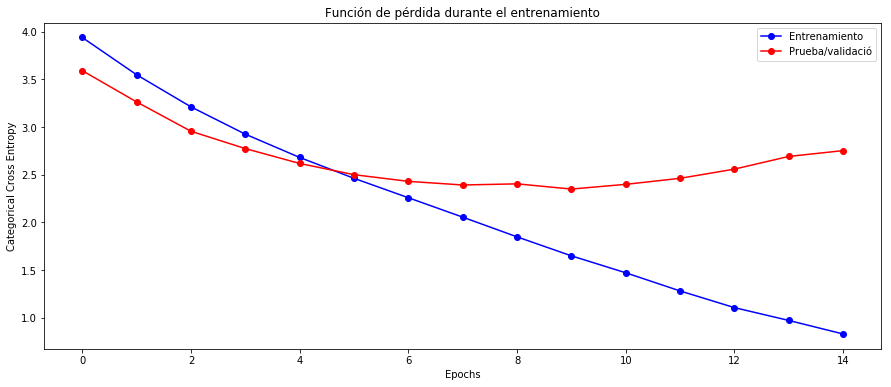

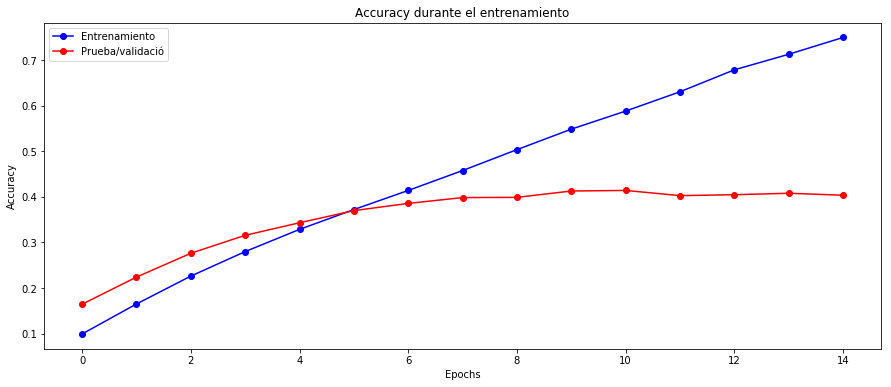

Tiempo de entrenamiento:  5613.034585475922 [s]
Accuracy sobre el conjunto de prueba [2.7533347278594973, 0.4034]


In [100]:
epochs=15
acc_test_m1 = model1.evaluate(x_test, y_test, verbose=0)
results(hist_m1, epochs, time_m1, acc_test_m1)

Con los gráficos anteriores es posible dar cuenta del overfitting que sufre esta red neuronal convolucional. Por un lado, en el comportamiento de la función de pérdida a través de los epochs, se pude ver como en el conjunto de entrenamiento se produce un decreciminto casi lineal, llegando en el último epoch a 0.83, tendiendo a pensar que con mas epochs este valo podría seguir disminuyendo, incluso llegando a 0. Mientras que el conjunto de prueba no se da el mismo comportamiento, por el contrario, se ve una insinuación de una parábola, en donde el punto más bajo se da en el epoch 9 con 2.35.

Por otro lado, con el accuracy a través de los epochs se ve un comportamiento inverso al anterior, pero similar en el sentido de que en el conjunto de entrenamiento aumenta prácticamente de forma lineal, haciendo pensar que si hubiesen más epochs en la ejecución se podria llegar a un accuracy perfecto, o sea la red estaría simplemente memorizando los datos del entrenamiento. Y en el conjunto de prueba, se ve el estancamiento producido en el 0.40. Así, ya en el último epoch se ve la diferencia entre el accuracy en los distintos conjuntos de datos, en el entrenamiento 0.75 y en la prueba 0.40, por lo que se puede apreciar el overfitting producido.

In [134]:
print('Función de pérdida final (entrenamiento): ', hist_m1.history['loss'][-1])
print('Función de pérdida media (prueba): ', hist_m1.history['val_loss'][9])
print('Función de pérdida final (prueba): ', hist_m1.history['val_loss'][-1])
print('Accuracy final (entrenamiento): ', hist_m1.history['acc'][-1])
print('Accuracy final (prueba): ', hist_m1.history['val_acc'][-1])

Función de pérdida final (entrenamiento):  0.829677004814148
Función de pérdida media (prueba):  2.350026950454712
Función de pérdida final (prueba):  2.7533347137451174
Accuracy final (entrenamiento):  0.7493
Accuracy final (prueba):  0.4034


> b) Debido al comportamiento de las curvas de entrenamiento, claramente se ve que se necesita un regularizador. Experimente utilizando Dropout con una tasa de 0.25 en las tandas convolucionales, elija donde situarlo, luego de la primera convolución, después de la segunda, solamente después del pooling, en todas o alguna forma que le parezca conveniente, de argumentos de ello. La idea es que se forme una idea de dónde conviene colocar el regularizador y porqué.



Para experimentar con dropout, se crean 7 redes, en donde cada una tiene situado el dropout en distintas partes de la arquitectura:

0. Primera tanda convolucional
1. Segunda tanda convolucional
2. Ambas tandas convolucionales
3. Primer pooling 
4. Segundo pooling
5. Ambos pooling
6. Ambas tandas convolucionales y pooling

In [29]:
hist_compare = []
time_compare = []
accu_compare = []
for i in range(7):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:],activation='relu'))
    model.add(Conv2D(32, (3, 3),padding='same',activation='relu'))
    if(i == 0 or i == 2 or i == 6):
        model.add(Dropout(0.25))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if(i == 3 or i == 5 or i == 6):
        model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
    model.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
    if(i == 1 or i == 2 or i == 6):
        model.add(Dropout(0.25))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if(i == 4 or i == 5 or i == 6):
        model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(100,activation='softmax'))
    model.summary()
    
    optimizer_ = SGD(lr=0.01,momentum=0.9)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer_, metrics=['accuracy'])

    start_time = time.time()
    hist_compare.append(model.fit(x_train, y_train, batch_size=128, epochs=15, verbose=0, 
                                  validation_data=(x_test,y_test)))
    time_compare.append(time.time() - start_time)
    accu_compare.append(model.evaluate(x_test, y_test, verbose=0))
    print("Fin red ", i)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 64)          0         
__________

Fin red  4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 8, 8, 64)          0         

Mediante la función *summary* se puede visuaizar la representación resumida de cada modelo. Aquí se ve en cada modelo dónde está puesto el dropout. Adempas se ve como lacantidad de parámetros se mantiene igual en todos los modelos, independiente de dónde o cuántos dropout se apliquen, dado que esta capa no agrega parámetros, solo trabaja sobre los que ya están.

In [143]:
print(tabulate(list(zip(range(1,8), [accu_compare[i][1] for i in range(len(accu_compare))], time_compare)),['Modelo', 'Accuracy', 'Tiempo [s]'], tablefmt = "fancy_grid"))

╒══════════╤════════════╤══════════════╕
│   Modelo │   Accuracy │   Tiempo [s] │
╞══════════╪════════════╪══════════════╡
│        1 │     0.4118 │      6339.24 │
├──────────┼────────────┼──────────────┤
│        2 │     0.4328 │      5742.52 │
├──────────┼────────────┼──────────────┤
│        3 │     0.4084 │      5917.83 │
├──────────┼────────────┼──────────────┤
│        4 │     0.4258 │      5764.74 │
├──────────┼────────────┼──────────────┤
│        5 │     0.44   │      5646.78 │
├──────────┼────────────┼──────────────┤
│        6 │     0.4413 │      5756.72 │
├──────────┼────────────┼──────────────┤
│        7 │     0.4305 │      6116.69 │
╘══════════╧════════════╧══════════════╛


De acuerdo a la tabla presentada, los modelos 5 y 6 son los que mejor se comportan, debido a que son los que tienen un accuracy más alto, y cuentan con los tiempos más bajo, 94.1 minutos y 95.9 minutos, respectivamente. 

Así, solo con estos resultados se elijiría la red con dropout luego de la segunda capa de pooling o en ambas capas de pooling, pero aún tenemos otro factor que análizar, la función de pérdida y accurracy a través de los epochs en el entrenamiento. 

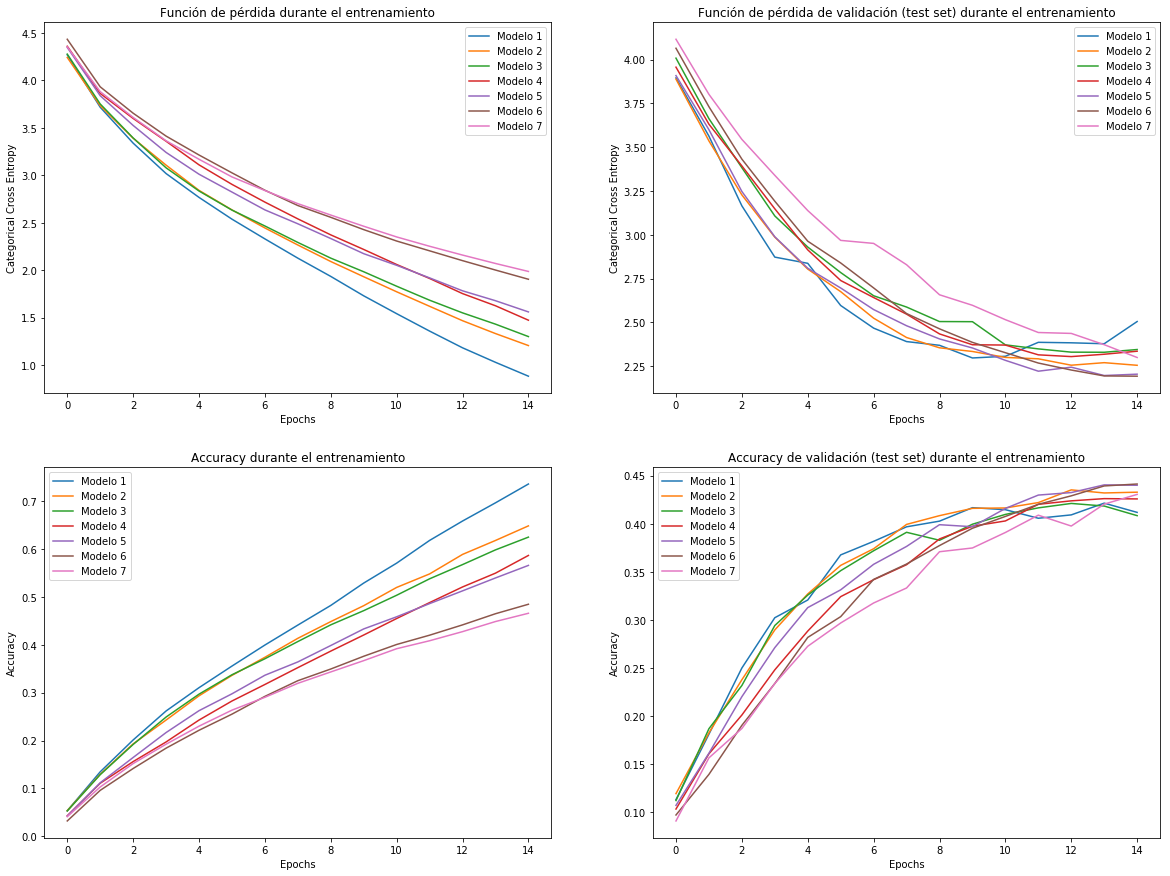

In [40]:
plt.figure(1, figsize=(20,15))

plt.subplot(221)
for i in range(7):
    plt.plot(range(epochs), hist_compare[i].history['loss'], label = 'Modelo %i' %(i+1))
plt.title('Función de pérdida durante el entrenamiento')
plt.ylabel('Categorical Cross Entropy')
plt.xlabel('Epochs')
plt.legend()
    
plt.subplot(222)
for i in range(7):
    plt.plot(range(epochs), hist_compare[i].history['val_loss'], label = 'Modelo %i' %(i+1))
plt.title('Función de pérdida de validación (test set) durante el entrenamiento')
plt.ylabel('Categorical Cross Entropy')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(223)
for i in range(7):
    plt.plot(range(epochs), hist_compare[i].history['acc'], label = 'Modelo %i' %(i+1))
plt.title('Accuracy durante el entrenamiento')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
    
plt.subplot(224)
for i in range(7):
    plt.plot(range(epochs), hist_compare[i].history['val_acc'], label = 'Modelo %i' %(i+1))
plt.title('Accuracy de validación (test set) durante el entrenamiento')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.show()

Analizando los gráficos anteriores, consideramos que los mejores modelos siguen siendo el Modelo 5 y 6, debido que no producen tanto overfitting como por ejemplo el Modelo 1 y porque son los que logran un mejor accuracy y función de pérdida. 

Fijando la atención en los modelos 5 y 6, línea morada y cafe, respectivamente, se ve que en el conjunto de entrenamiento son los que tienen un "peor" comportamiento, tanto en función de pérdida, que son los más altos, como en accuracy, que son lo que se mantienen más bajo. Sin embargo, al revisar su contraparte en el conjunto de prueba, se ve que que estos modelos son los que alcanzan mejores resultado, menor función de pérdida y mayor accuracy. Viendo este comportamiento, da a pensar que estas redes efectivamente están aprendiendo incrementalmene, y no memorizando, como tal vez lo está haciendo el modelo 1. Por lo que si a los modelos 5 y 6 se les dan más epochs para entrenar se podría inducir que se lograrán mejores resultados.

Debido a lo anterior se infiere una idea de dónde convendría colocar el regularizador dropout. Convendría ubicar dropout junto con la capa de pooling, en este caso con max-pooling, ya sea ubicándola luego de la última capa de pooling o luego de todas las capas de pooling. El mejor comportamiento logrado con este tipo de arquitectura se puede deber a los efectos combinados de cada capa. Primero con la capa de pooling permite reducir las dimensiones espaciales de la entrada (ancho x alto), rescatando la característica principal de una ventana (2x2 en este caso). Y luego, al aplicar dropout se produce una segunda reducción, pero en este caso sobre las neuronas utilizadas, quedando activas solo algunas, lo que permitiría a la red fijarse solo en ciertas partes de la imagen, y esas partes ya serían lo suficientemente buenas y reducidas para capturar y aprender lo realmente importante.

> c) Como pre entrenamiento de la misma red definida en a) de una manera no supervisada se trabajará con un autoencoder convolucional, el cual no necesita etiqueta de los datos por lo que se puede aprovechar de transferir lo aprendido con datos sin conocer si pertenecen a la misma categoría o no. Comente y analice si esto mejora lo visto en a). Utilice todas las imágenes no etiquetadas que desee.

Autoencoder es un algoritmo no supervisado que tma una imagen como input y luego en la salida la intenta reconstruir, generando en la capa oculta una representación de los datos. Generalmente son reductores de dimensionalidad, por lo que su representación es comprimida.

In [44]:
hidden_layer1 = 32  #como model1
hidden_layer2 = 64
loss_='binary_crossentropy'
activation_1 = activation_2 = 'relu'
decoder_activation = decoder_activation2 = 'sigmoid'
hist_compare2 = []
time_compare2 = []
accu_compare2 = []

In [47]:
###BUILD AUTOENCODER1
print('Autoencoder 1')
input_img = Input(shape=x_train.shape[1:])
encoded1 = Conv2D(hidden_layer1, (3, 3),activation=activation_1,padding='same')(input_img)
decoded1 = Conv2D(3, (3, 3), activation=decoder_activation, padding='same')(encoded1)
autoencoder1 = Model(input_img, decoded1)
autoencoder1.compile(optimizer='adam', loss=loss_)
autoencoder1.summary()
start_time = time.time()
hist_compare2.append(autoencoder1.fit(x_train, x_train, epochs=15, batch_size=128, verbose=0,
                                      validation_data=(x_test, x_test)))
time_compare2.append(time.time() - start_time)
#accu_compare2.append(autoencoder1.evaluate(x_test, y_test, verbose=0))
autoencoder1.save('autoencoder_layer1.h5')
###BUILD AUTOENCODER2
encoded1 = autoencoder1.layers[1](autoencoder1.input)

#AUTOENCODER2
print('Autoencoder 2')
encoded2 = Conv2D(hidden_layer2,(3, 3), activation=activation_2, padding='same')(encoded1) 
decoded2 = Conv2D(hidden_layer1,(3, 3), activation=decoder_activation2,padding='same')(encoded2) 
#finish AUTOENCODER2
decoded1 = autoencoder1.layers[-1](decoded2)
autoencoder2 = Model(autoencoder1.input, decoded1) #all model
#autoencoder1 set fixed
autoencoder2.layers[1].trainable=False
autoencoder2.layers[-1].trainable=False
autoencoder2.compile(optimizer='adam', loss=loss_)
autoencoder2.summary()
start_time = time.time()
hist_compare2.append(autoencoder2.fit(x_train, x_train, epochs=10, batch_size=128, verbose=0,
                                      validation_data=(x_test, x_test)))
time_compare2.append(time.time() - start_time)
#accu_compare2.append(autoencoder2.evaluate(x_test, y_test, verbose=0))
autoencoder2.save('autoencoder_layer2.h5')

Autoencoder 1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 32, 32, 3)         867       
Total params: 1,763
Trainable params: 1,763
Non-trainable params: 0
_________________________________________________________________
Autoencoder 1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 32, 32, 32)        896       
______________________________________________

In [51]:
#FINE TUNNING
print('Fine tunning - Entrenamiento con autoencoders')
model2 = Sequential()
model2.add(Conv2D(hidden_layer1,(3, 3),padding='same',activation=activation_1,input_shape=x_train.shape[1:]))
model2.layers[-1].set_weights(autoencoder1.layers[1].get_weights())
model2.add(Conv2D(hidden_layer2, (3, 3),padding='same',activation=activation_2))
model2.layers[-1].set_weights(autoencoder2.layers[2].get_weights())
model2.add(MaxPooling2D(pool_size=(2, 2)))
# #rest of the model
# model2.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
# model2.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
# model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Flatten())
model2.add(Dense(1024, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(100, activation='softmax'))

optimizer_ = SGD(lr=0.01,momentum=0.9)
model2.compile(loss='categorical_crossentropy', optimizer=optimizer_, metrics=['accuracy'])
model2.summary()
start_time = time.time()
hist_compare2.append(model2.fit(x_train, y_train, batch_size=128,epochs=15, verbose=1, 
                                validation_data=(x_test, y_test)))
time_compare2.append(time.time() - start_time)

Fine tunning - Entrenamiento con autoencoders
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 16384)             0         
_________________________________________________________________
dense_23 (Dense)             (None, 1024)              16778240  
_________________________________________________________________
dropout_27 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_24 (Dense)             (

In [58]:
acc_m2= model2.evaluate(x_test, y_test, verbose=0)

Realizando la comparación con la red entrenada en a)

In [144]:
print(tabulate(list(zip(['Red convolucional (a)', 'Red convolucional con autoencoder (c)'], [acc_test_m1[1], acc_m2[1]], [time_m1, time_compare2[-1]])),['Modelo', 'Accuracy', 'Tiempo [s]'], tablefmt = "fancy_grid"))

╒═══════════════════════════════════════╤════════════╤══════════════╕
│ Modelo                                │   Accuracy │   Tiempo [s] │
╞═══════════════════════════════════════╪════════════╪══════════════╡
│ Red convolucional (a)                 │     0.4034 │      5613.03 │
├───────────────────────────────────────┼────────────┼──────────────┤
│ Red convolucional con autoencoder (c) │     0.3853 │      6544.28 │
╘═══════════════════════════════════════╧════════════╧══════════════╛


Con esta tabla se puede ver que según estos criterios claramente no se produce una mejora con el autoencoder, debido a que la red con este último método se demora 15.5 minutos más en entrenar y tiene 0.0181 menos de accuracy .

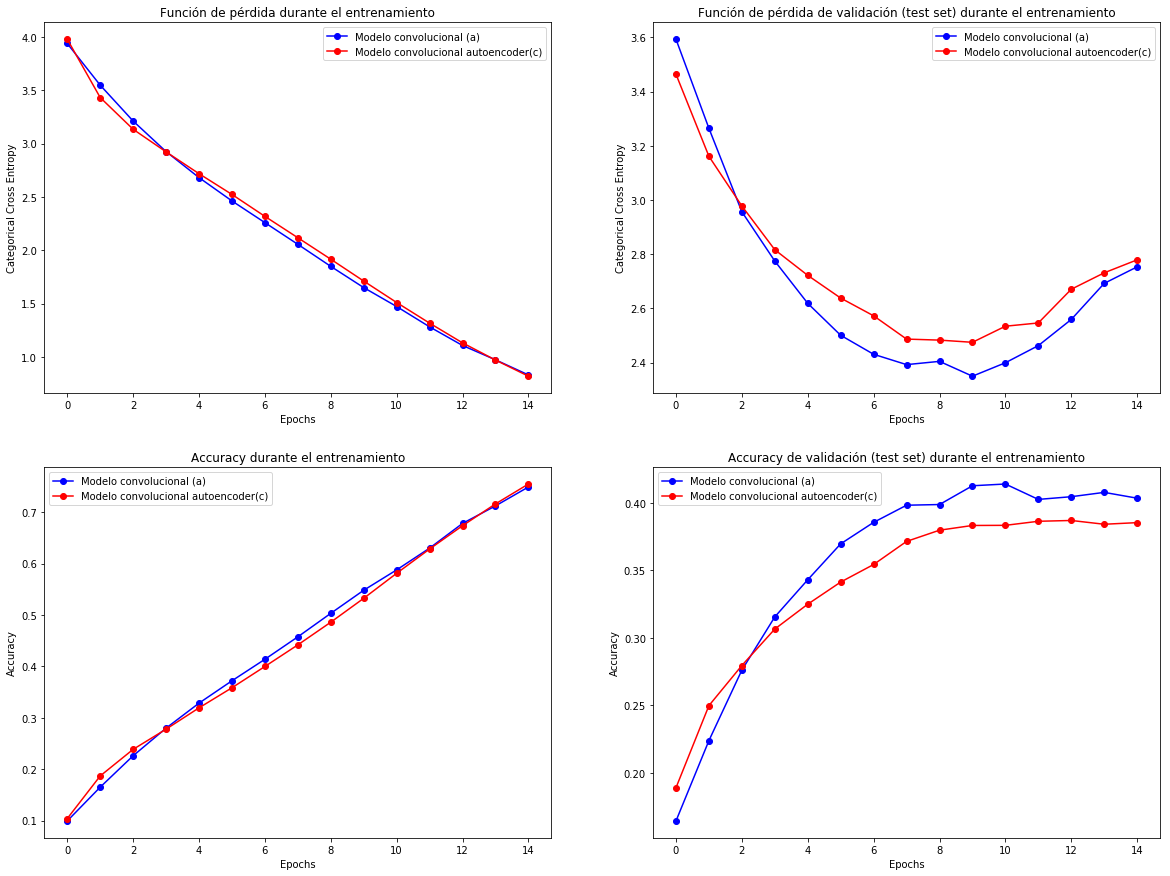

In [62]:
plt.figure(1, figsize=(20,15))

plt.subplot(221)
plt.plot(range(epochs), hist_m1.history['loss'], 'bo-', label = 'Modelo convolucional (a)')
plt.plot(range(epochs), hist_compare2[-1].history['loss'], 'ro-', label = 'Modelo convolucional autoencoder(c)')
plt.title('Función de pérdida durante el entrenamiento')
plt.ylabel('Categorical Cross Entropy')
plt.xlabel('Epochs')
plt.legend()
    
plt.subplot(222)
plt.plot(range(epochs), hist_m1.history['val_loss'], 'bo-', label = 'Modelo convolucional (a)')
plt.plot(range(epochs), hist_compare2[-1].history['val_loss'], 'ro-', label = 'Modelo convolucional autoencoder(c)')
plt.title('Función de pérdida de validación (test set) durante el entrenamiento')
plt.ylabel('Categorical Cross Entropy')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(223)
plt.plot(range(epochs), hist_m1.history['acc'], 'bo-', label = 'Modelo convolucional (a)')
plt.plot(range(epochs), hist_compare2[-1].history['acc'], 'ro-', label = 'Modelo convolucional autoencoder(c)')
plt.title('Accuracy durante el entrenamiento')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
    
plt.subplot(224)
plt.plot(range(epochs), hist_m1.history['val_acc'], 'bo-', label = 'Modelo convolucional (a)')
plt.plot(range(epochs), hist_compare2[-1].history['val_acc'], 'ro-', label = 'Modelo convolucional autoencoder(c)')
plt.title('Accuracy de validación (test set) durante el entrenamiento')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.show()

Ahora, revisando la función de pérdida y accuracy a través de los epochs en el entrenamiento, se ve que en el conjunto de entrenamiento tienen un comportamiento muy similar, incluso en algunos puntos las curvas están sobrepuestas. Pero en el conjunto de prueba se nota la diferencia, en donde la red del modelo convolucional sin autoencoder (letra a) obtiene mejores resultados (menor función de pérdida y mayor accuracy).

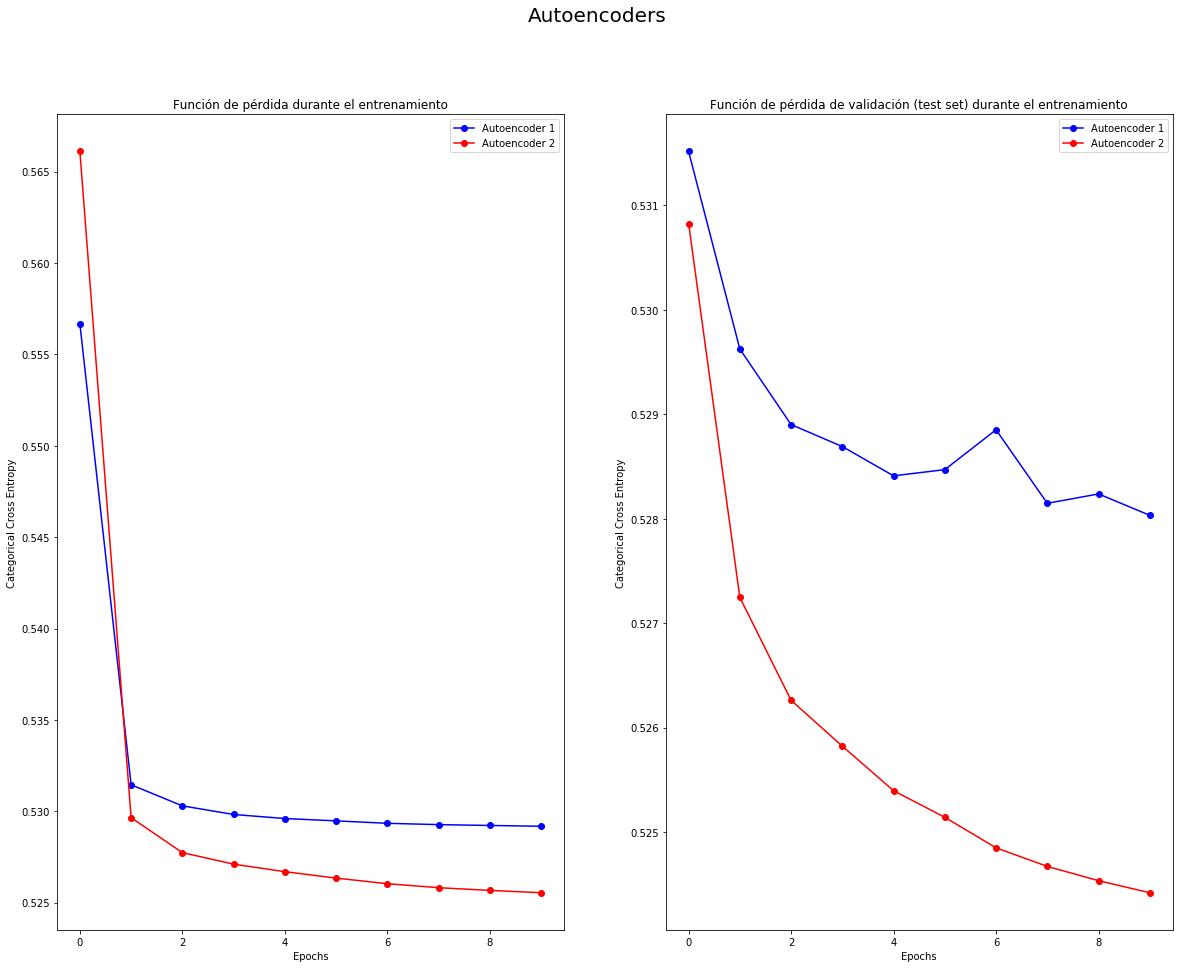

In [116]:
epochs = 10
plt.figure(1, figsize=(20,15))
plt.suptitle('Autoencoders', fontsize=20)

plt.subplot(121)
plt.plot(range(epochs), hist_compare2[0].history['loss'][:10], 'bo-', label = 'Autoencoder 1')
plt.plot(range(epochs), hist_compare2[1].history['loss'], 'ro-', label = 'Autoencoder 2')
plt.title('Función de pérdida durante el entrenamiento')
plt.ylabel('Categorical Cross Entropy')
plt.xlabel('Epochs')
plt.legend()
    
plt.subplot(122)
plt.plot(range(epochs), hist_compare2[0].history['val_loss'][:10], 'bo-', label = 'Autoencoder 1')
plt.plot(range(epochs), hist_compare2[1].history['val_loss'], 'ro-', label = 'Autoencoder 2')
plt.title('Función de pérdida de validación (test set) durante el entrenamiento')
plt.ylabel('Categorical Cross Entropy')
plt.xlabel('Epochs')
plt.legend()

plt.show()

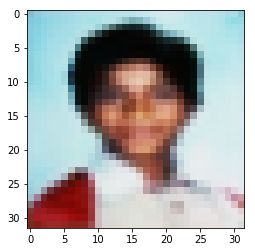

In [86]:
plt.imshow(autoencoder1.predict(x_train[:10])[3])
plt.show()

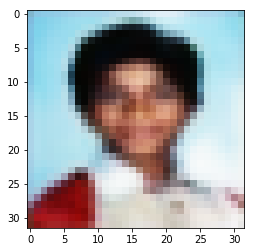

In [87]:
plt.imshow(autoencoder2.predict(x_train[:10])[3])
plt.show()

> d) Otra forma de hacer lo que se conoce como *transfer learning* es utilizar el conocimiento (los parámetros) aprendido por una red entrenada con millones de imágenes, y tomar estos parámetros como los pre entrenados. Para esto se utilizará el modelo VGG16 [7] proporcionado a través de la interfaz de keras. Visualice el modelo y sus 23 capas. Para esta instancia se utilizará todo lo aprendido por las capas convolucionales, es decir, se eliminan las capas densas del modelo y se agregan unas nuevas a ser entrenadas desde cero.
```python
from keras.applications import VGG16
#LOAD PRETRAINED MODEL 
input_tensor=Input(shape=x_train.shape[1:])
modelVGG = VGG16(weights='imagenet', include_top=False,input_tensor=input_tensor )
features_train = modelVGG.predict(x_train)
features_test = modelVGG.predict(x_test)
modelVGG.summary()
```

VGG16 es un modelo que Keras ya tiene preentrenado en el conjunto de datos ImageNet. La arquitectura de esta red cuenta con 13 capas convolucionales, 3 capas completamente contectadas y 4 capas de max-pooling, organizadas como lo indica la siguiente imagen:

![VGG16_1](https://cdn-images-1.medium.com/max/1400/0*V1muWIDnPVwZUuEv.png "Arquitectura VGG16")

Con cada max-pooling que se realiza luego de una tanda de capas convolucionales, la dimensionalidad de la entrada va disminuyendo a medida que avanza en la red, como en el siguiente ejemplo:


![VGG16_2](https://www.cs.toronto.edu/~frossard/post/vgg16/vgg16.png "Dimensionalidades VGG16")

In [88]:
#LOAD PRETRAINED MODEL 
input_tensor=Input(shape=x_train.shape[1:])
modelVGG = VGG16(weights='imagenet', include_top=False,input_tensor=input_tensor )
features_train = modelVGG.predict(x_train)
features_test = modelVGG.predict(x_test)
modelVGG.summary()

58892288/58889256 [==============================] - 26s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_poo

El resumen de la red VGG16 presentado anteriormente no cuenta con las ultimas capas, densas y softmax, dado que para hacer transfer learning, en este caso se utilizan los pesos entrenados por esta red en sus capas convolucinales.

In [146]:
print("Dimensión entrenamiento pre-VGG16: ", x_train.shape, "post-VGG16: ", features_train.shape)
print("Dimensión prueba pre-VGG16: ", x_test.shape, "post-VGG16: ", features_test.shape)

Dimensión entrenamiento pre-VGG16:  (50000, 32, 32, 3) post-VGG16:  (50000, 1, 1, 512)
Dimensión prueba pre-VGG16:  (10000, 32, 32, 3) post-VGG16:  (10000, 1, 1, 512)


Se puede ver como la dimensionalidad de los conjuntos de entrenamiento y prueba cambian una vez, que se aplican las capas de VGG16. En un comienzo cada imagen era de 32x32 con 3 canales RGB, y después cada imagen queda de 1x1x512, lo que se podría ver como que cada imagen es de 1x1 con 512 caraterísticas. 

> e) Entrene esta red agregando una capa densa de 1024 neuronas seguido de un dropout de 0.5, finalmente es necesario agregar la capa de clasificación para las 100 clases. Utilice la misma configuración del optimizador para que las comparaciones sean válidas. Entrene unicamente por 10 *epochs* ¿Qué sucede? Comente.
```python
model = Sequential()
model.add(Flatten(input_shape=features_train.shape[1:]))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
...#clasification
model.compile(optimizer=optimizer_,loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(features_train, y_train,epochs=epochs_, batch_size=128,verbose=1,validation_data=(features_test,y_test))
```

A continuación se agregan dos nuevas capas densas al modelo VGG16 de la pregunta anterior. Una con 1024 neuronas, activación ReLU y dropout, y otra con 100 neuronas softmax para poder realizar la predicción.

In [90]:
epochs_ = 10

model3 = Sequential()
model3.add(Flatten(input_shape=features_train.shape[1:]))
model3.add(Dense(1024, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(100,activation='softmax'))
model3.summary()
optimizer_ = SGD(lr=0.01,momentum=0.9)
model3.compile(optimizer=optimizer_, loss='categorical_crossentropy', metrics=['accuracy'])
start_time = time.time()
hist_m3 = model3.fit(features_train, y_train,epochs=epochs_, batch_size=128,verbose=1,
           validation_data=(features_test,y_test))
time_m3 = time.time() - start_time


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_13 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dropout_28 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 100)               102500    
Total params: 627,812
Trainable params: 627,812
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 10s 201us/step - loss: 3.9589 - acc: 0.1096 - val_loss: 3.3968 - val_acc: 0.2108
Epoch 2/10
50000/50000 [==============================] - 9s 180us/step - loss:

En el resumen del modelo se ve como los únicos parámetros que tiene que aprender por ahora son los de las capas creadas recientemente.

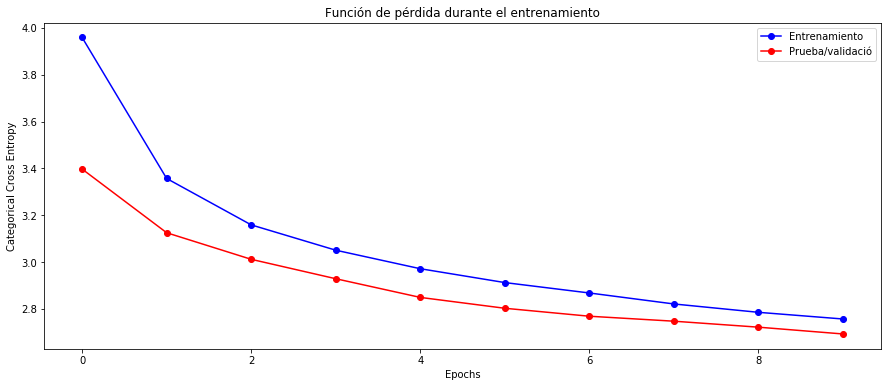

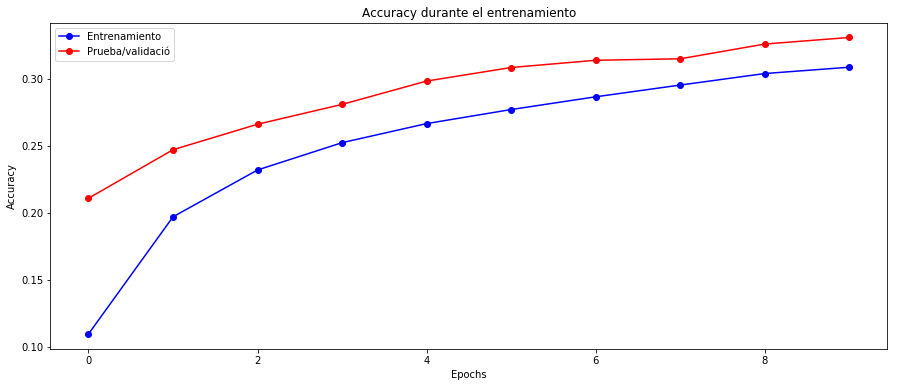

Tiempo de entrenamiento:  91.13662552833557 [s]


In [125]:
epochs_ = 10
plot_loss(hist_m3, epochs)
plot_accuracy(hist_m3, epochs)
print('Tiempo de entrenamiento: ', time_m3, '[s]')

Es importante notar que el tiempo de entrenamiento es considerablemente menor que en los casos anteriores, pues se demora tan solo 1.5 minutos.

En cuanto al comportamiento de la red durante los epochs en el entrenamiento no logra los mejores resultados. A continuación se presentan los valores de los mejores resultados presentados en el gráfico anterior:

In [148]:
print("Mejor pérdida en el conjunto de entrenaminto: ",min(hist_m3.history['loss']))
print("Mejor pérdida en el conjunto de prueba: ",min(hist_m3.history['val_loss']))
print("Mejor accuracy en el conjunto de entrenaminto: ",min(hist_m3.history['acc']))
print("Mejor accuracy en el conjunto de prueba: ",min(hist_m3.history['val_acc']))

Mejor pérdida en el conjunto de entrenaminto:  2.756518670425415
Mejor pérdida en el conjunto de prueba:  2.6925548683166505
Mejor accuracy en el conjunto de entrenaminto:  0.10960000000476837
Mejor accuracy en el conjunto de prueba:  0.2108


Así, se ve que estos valores son deficientes en comparación a los anteriores, y para realizar mejor comparación se presentan los siguientes gráficos que comparan la función de pérdida y accuracy durante el entrenamiento para el conjunto de entrenamiento y de prueba.

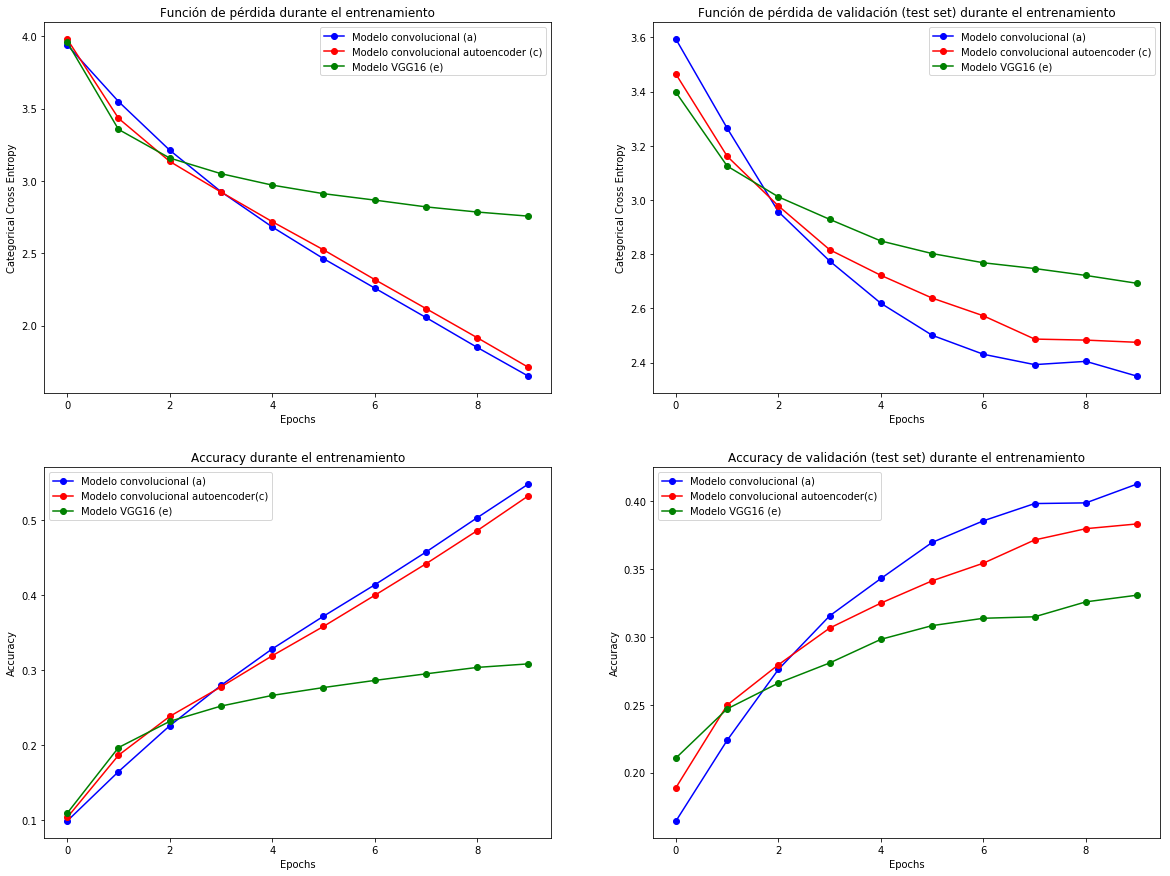

In [124]:
plt.figure(1, figsize=(20,15))

plt.subplot(221)
plt.plot(range(epochs_), hist_m1.history['loss'][:epochs_], 'bo-', label = 'Modelo convolucional (a)')
plt.plot(range(epochs_), hist_compare2[-1].history['loss'][:epochs_], 'ro-', label = 'Modelo convolucional autoencoder (c)')
plt.plot(range(epochs_), hist_m3.history['loss'], 'go-', label = 'Modelo VGG16 (e)')
plt.title('Función de pérdida durante el entrenamiento')
plt.ylabel('Categorical Cross Entropy')
plt.xlabel('Epochs')
plt.legend()
    
plt.subplot(222)
plt.plot(range(epochs_), hist_m1.history['val_loss'][:epochs_], 'bo-', label = 'Modelo convolucional (a)')
plt.plot(range(epochs_), hist_compare2[-1].history['val_loss'][:epochs_], 'ro-', label = 'Modelo convolucional autoencoder (c)')
plt.plot(range(epochs_), hist_m3.history['val_loss'], 'go-', label = 'Modelo VGG16 (e)')
plt.title('Función de pérdida de validación (test set) durante el entrenamiento')
plt.ylabel('Categorical Cross Entropy')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(223)
plt.plot(range(epochs_), hist_m1.history['acc'][:epochs_], 'bo-', label = 'Modelo convolucional (a)')
plt.plot(range(epochs_), hist_compare2[-1].history['acc'][:epochs_], 'ro-', label = 'Modelo convolucional autoencoder(c)')
plt.plot(range(epochs_), hist_m3.history['acc'], 'go-', label = 'Modelo VGG16 (e)')
plt.title('Accuracy durante el entrenamiento')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
    
plt.subplot(224)
plt.plot(range(epochs_), hist_m1.history['val_acc'][:epochs_], 'bo-', label = 'Modelo convolucional (a)')
plt.plot(range(epochs_), hist_compare2[-1].history['val_acc'][:epochs_], 'ro-', label = 'Modelo convolucional autoencoder(c)')
plt.plot(range(epochs_), hist_m3.history['val_acc'], 'go-', label = 'Modelo VGG16 (e)')
plt.title('Accuracy de validación (test set) durante el entrenamiento')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.show()

La curva verde representa la red que se entrena en base a los parámetros ya aprendidos en VGG16, comprándola con la red convolucional sin y con autoencoder se ve claramente un peor comportamiento, en especial en el cojunto de entrenamiento, tanto en la función de pérdida como en el accuracy. Algo curioso de notar es que en los dos primeros epoch de las cuatro situaciones el modelo actual es mejor que los otros dos, y apartir del cuarto epoch se comienza a notar la gran diferencia de rendimiento.

> f) Agregue una capa de normalización (*Batch Normalization* [8]) de las activaciones en las capas densas, esto es, restar por la media del batch y dividir por la desviación estándar. Vuelva a entrenar el modelo con la misma configuración pero ahora por **15 *epochs***. Comente lo observado y compare las curvas de convergencia con los modelos anteriores ¿Por qué esto mejora a lo presentado en e)? Realice los mismos gráficos que en a) a través del número de *epochs* y comente sobre el tiempo de ejecución de este entrenamiento.
```python
model = Sequential()
model.add(Flatten(input_shape=features_train.shape[1:]))
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
...
```

Batch Normalization es una técnica desarrollada para evitar/reducir el problema de *internal covariate shift*, que ocurre cuando la distribución de la entradas en cada capa cambia significativamente durante en el entrenamiento debido a la actualización de los parámetros, lo que también hace que el entrenamiento será más lento. Así, la aplicación de batch normalización realiza una normalización a la entrada por batch, o sea se resta por la media del batch y divide por su desviación estándar.

Dado que VGG16 nació antes que batch normalization, los parámetros ya aprendidos tienen este problema de *internal covariate shift*, por lo que al momento de aplicar las capas densas se aplica esta técnica.

In [102]:
epochs_ = 15
model4 = Sequential()
model4.add(Flatten(input_shape=features_train.shape[1:]))
model4.add(BatchNormalization())
model4.add(Dense(1024, activation='relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.5))
model4.add(Dense(100,activation='softmax'))
model4.summary()
optimizer_ = SGD(lr=0.01,momentum=0.9)
model4.compile(optimizer=optimizer_, loss='categorical_crossentropy', metrics=['accuracy'])
start_time = time.time()
hist_m4 = model4.fit(features_train, y_train,epochs=epochs_, batch_size=128,verbose=1,
           validation_data=(features_test,y_test))
time_m4 = time.time() - start_time

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_16 (Flatten)         (None, 512)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
dense_29 (Dense)             (None, 1024)              525312    
_________________________________________________________________
batch_normalization_4 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_30 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 100)               102500    
Total params: 633,956
Trainable params: 630,884
Non-trainable params: 3,072
_________________________________________________________________


In [103]:
acc_test_m4 = model4.evaluate(features_test, y_test,verbose=0)

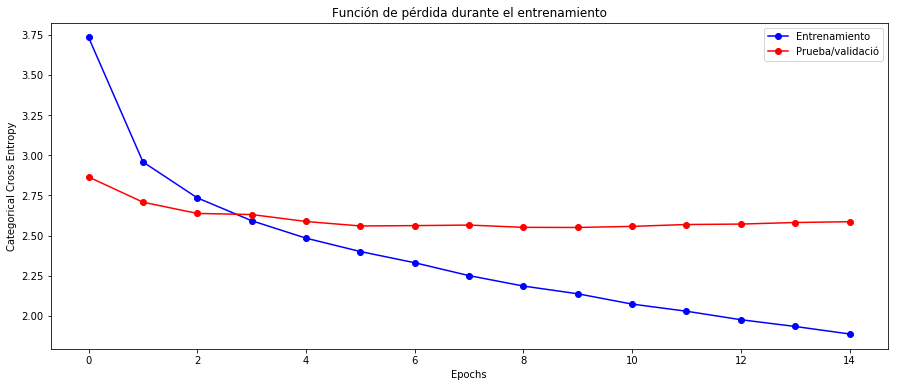

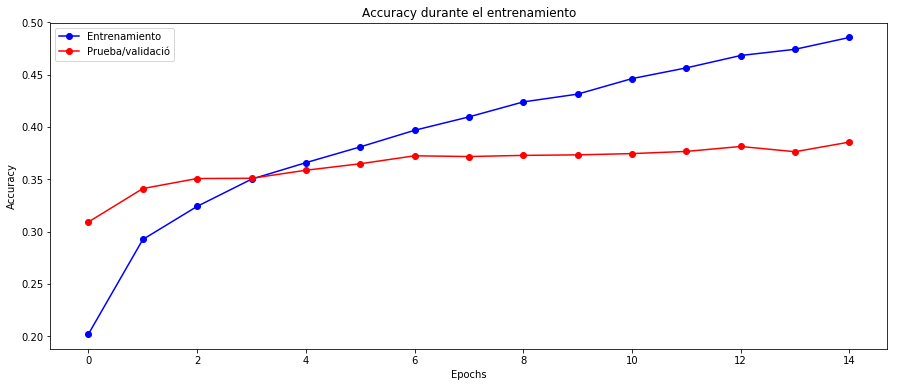

Tiempo de entrenamiento:  190.42406797409058 [s]
Accuracy sobre el conjunto de prueba [2.5858650981903075, 0.3855]


In [126]:
epochs_ = 15
results(hist_m4, epochs_, time_m4, acc_test_m4)

El tiempo que toma para el entrenamiento es mayor a la red entrenada en el punto anterior, pero aún así sigue siendo bastante menor a las primeras, tomando 3.1 minutos.

También se ve como el accuracy sobre el conjunto de prueba es similar con el mejor lograo anteriormente, en el modelo convolucional con autoencoder.

Revisando los mejores valores de función de pérdida y accuracy en los conjuntos de entrenamiento y prueba:

In [149]:
print("Mejor pérdida en el conjunto de entrenaminto: ",min(hist_m4.history['loss']))
print("Mejor pérdida en el conjunto de prueba: ",min(hist_m4.history['val_loss']))
print("Mejor accuracy en el conjunto de entrenaminto: ",min(hist_m4.history['acc']))
print("Mejor accuracy en el conjunto de prueba: ",min(hist_m4.history['val_acc']))

Mejor pérdida en el conjunto de entrenaminto:  1.8872604219055176
Mejor pérdida en el conjunto de prueba:  2.55003588142395
Mejor accuracy en el conjunto de entrenaminto:  0.20213999999046325
Mejor accuracy en el conjunto de prueba:  0.3092


Se da cuenta que estos valores son bastante mejores que los anteriores, dejando claro lo que produce la capa de batch normalization.

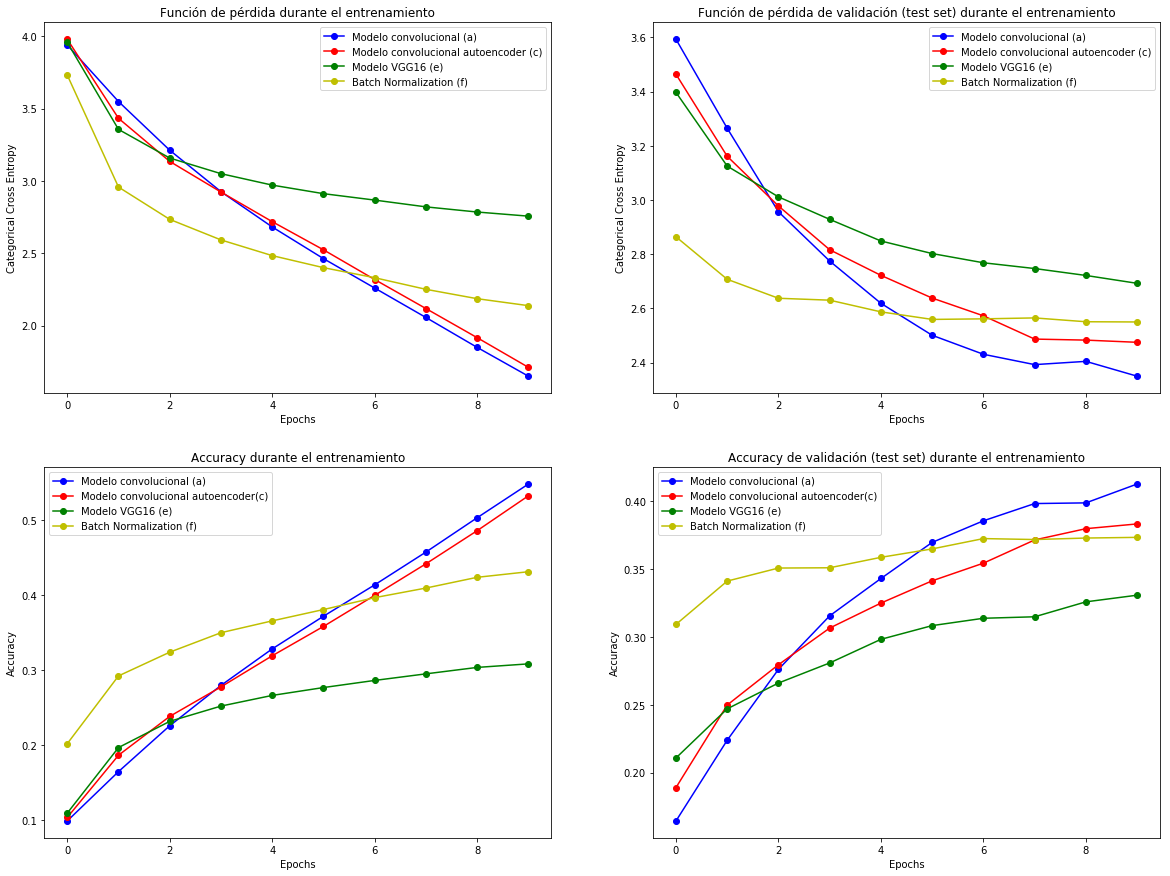

In [129]:
epochs_ = 10
plt.figure(1, figsize=(20,15))

plt.subplot(221)
plt.plot(range(epochs_), hist_m1.history['loss'][:epochs_], 'bo-', label = 'Modelo convolucional (a)')
plt.plot(range(epochs_), hist_compare2[-1].history['loss'][:epochs_], 'ro-', label = 'Modelo convolucional autoencoder (c)')
plt.plot(range(epochs_), hist_m3.history['loss'], 'go-', label = 'Modelo VGG16 (e)')
plt.plot(range(epochs_), hist_m4.history['loss'][:epochs_], 'yo-', label = 'Batch Normalization (f)')
plt.title('Función de pérdida durante el entrenamiento')
plt.ylabel('Categorical Cross Entropy')
plt.xlabel('Epochs')
plt.legend()
    
plt.subplot(222)
plt.plot(range(epochs_), hist_m1.history['val_loss'][:epochs_], 'bo-', label = 'Modelo convolucional (a)')
plt.plot(range(epochs_), hist_compare2[-1].history['val_loss'][:epochs_], 'ro-', label = 'Modelo convolucional autoencoder (c)')
plt.plot(range(epochs_), hist_m3.history['val_loss'], 'go-', label = 'Modelo VGG16 (e)')
plt.plot(range(epochs_), hist_m4.history['val_loss'][:epochs_], 'yo-', label = 'Batch Normalization (f)')
plt.title('Función de pérdida de validación (test set) durante el entrenamiento')
plt.ylabel('Categorical Cross Entropy')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(223)
plt.plot(range(epochs_), hist_m1.history['acc'][:epochs_], 'bo-', label = 'Modelo convolucional (a)')
plt.plot(range(epochs_), hist_compare2[-1].history['acc'][:epochs_], 'ro-', label = 'Modelo convolucional autoencoder(c)')
plt.plot(range(epochs_), hist_m3.history['acc'], 'go-', label = 'Modelo VGG16 (e)')
plt.plot(range(epochs_), hist_m4.history['acc'][:epochs_], 'yo-', label = 'Batch Normalization (f)')
plt.title('Accuracy durante el entrenamiento')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
    
plt.subplot(224)
plt.plot(range(epochs_), hist_m1.history['val_acc'][:epochs_], 'bo-', label = 'Modelo convolucional (a)')
plt.plot(range(epochs_), hist_compare2[-1].history['val_acc'][:epochs_], 'ro-', label = 'Modelo convolucional autoencoder(c)')
plt.plot(range(epochs_), hist_m3.history['val_acc'], 'go-', label = 'Modelo VGG16 (e)')
plt.plot(range(epochs_), hist_m4.history['val_acc'][:epochs_], 'yo-', label = 'Batch Normalization (f)')
plt.title('Accuracy de validación (test set) durante el entrenamiento')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.show()

Al comparar con todos los modelos entrenados anteriormente, se ve como en un comienzo y aproximadamente hasta el epoch 5 el comportamiento de la red actual (curva amarilla) es considerablemente mejor, pero luego de esto comienza a quedar estancada, pero aún así tiene un comportamiento mucho mejor que la red basada VGG16 sin batch normalization (curva verde).


> g) Anteriormente se dejaron fijas las capas de convolución de VGG16, ahora experimente comentando sobre la convergencia y el tiempo de ejecución el entrenar la última tanda de convoluciones de VGG16, es decir, tome como punto inicial los pesos pre entrenados de esta red en *Imagenet* y entrenelos para este problema.
```python
#LOAD PRETRAINED MODEL 
input_tensor=Input(shape=x_train.shape[1:])
modelVGG = VGG16(weights='imagenet', include_top=False,input_tensor=input_tensor )
salida_vgg = modelVGG.get_layer('block4_pool').output_shape
model = Sequential()
model.add(Conv2D(512,(3, 3),input_shape=salida_vgg[1:],activation='relu',padding='same'))
model.add(Conv2D(512,(3, 3),activation='relu',padding='same'))
model.add(Conv2D(512,(3, 3),activation='relu',padding='same'))
model.add(MaxPooling2D((2, 2),strides=(2,2)))    
##dense section
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(100, activation='softmax'))
#delete last 4 layers of VGG16 and transfer the weight to new model
modelVGG.layers.pop() #delete last maxpooling
for i in np.arange(2,-1,-1):
    last = modelVGG.layers.pop() #delete convolutional layers
    model.layers[i].set_weights(last.get_weights())
from keras.models import Model
crop_modelVGG = Model(inputs=modelVGG.input, outputs=modelVGG.layers[-1].output)
features_train = crop_modelVGG.predict(x_train)
features_test = crop_modelVGG.predict(x_test)
#train it
model.compile(optimizer=optimizer_,loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(features_train,y_train,epochs=15,batch_size=128,verbose=1,validation_data=(features_test,y_test))
```

In [110]:
#LOAD PRETRAINED MODEL 
input_tensor=Input(shape=x_train.shape[1:])
modelVGG = VGG16(weights='imagenet', include_top=False,input_tensor=input_tensor )
salida_vgg = modelVGG.get_layer('block4_pool').output_shape
model5 = Sequential()
model5.add(Conv2D(512,(3, 3),input_shape=salida_vgg[1:],activation='relu',padding='same'))
model5.add(Conv2D(512,(3, 3),activation='relu',padding='same'))
model5.add(Conv2D(512,(3, 3),activation='relu',padding='same'))
model5.add(MaxPooling2D((2, 2),strides=(2,2)))    
##dense section
model5.add(Flatten())
model5.add(BatchNormalization())
model5.add(Dense(1024, activation='relu'))
model5.add(BatchNormalization())
model5.add(Dropout(0.5))
model5.add(Dense(100, activation='softmax'))
#delete last 4 layers of VGG16 and transfer the weight to new model
modelVGG.layers.pop() #delete last maxpooling
for i in np.arange(2,-1,-1):
    last = modelVGG.layers.pop() #delete convolutional layers
    model5.layers[i].set_weights(last.get_weights())
crop_modelVGG = Model(inputs=modelVGG.input, outputs=modelVGG.layers[-1].output)
features_train_2 = crop_modelVGG.predict(x_train)
features_test_2 = crop_modelVGG.predict(x_test)
#train it
optimizer_ = SGD(lr=0.01,momentum=0.9)
model5.compile(optimizer=optimizer_,loss='categorical_crossentropy', metrics=['accuracy'])
start_time = time.time()
hist_m5 = model5.fit(features_train_2,y_train,epochs=15,batch_size=128,verbose=1,
                     validation_data=(features_test_2,y_test))
time_m5 = time.time() - start_time

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 623s 12ms/step - loss: 5.2378 - acc: 0.0188 - val_loss: 4.6699 - val_acc: 0.0207
Epoch 2/15
50000/50000 [==============================] - 622s 12ms/step - loss: 5.0209 - acc: 0.0191 - val_loss: 4.6139 - val_acc: 0.0246
Epoch 3/15
50000/50000 [==============================] - 610s 12ms/step - loss: 4.9464 - acc: 0.0203 - val_loss: 4.7384 - val_acc: 0.0150
Epoch 4/15
50000/50000 [==============================] - 601s 12ms/step - loss: 4.8752 - acc: 0.0215 - val_loss: 4.6063 - val_acc: 0.0235
Epoch 5/15
50000/50000 [==============================] - 615s 12ms/step - loss: 4.8405 - acc: 0.0220 - val_loss: 4.6702 - val_acc: 0.0168
Epoch 6/15
50000/50000 [==============================] - 622s 12ms/step - loss: 4.7983 - acc: 0.0229 - val_loss: 4.6526 - val_acc: 0.0258
Epoch 7/15
50000/50000 [==============================] - 700s 14ms/step - loss: 4.7637 - acc: 0.0230 - val_loss: 4.

In [150]:
model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_69 (Conv2D)           (None, 2, 2, 512)         2359808   
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 2, 2, 512)         2359808   
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 2, 2, 512)         2359808   
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 1, 1, 512)         0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 512)               0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 512)               2048      
_________________________________________________________________
dense_39 (Dense)             (None, 1024)              525312    
__________

In [112]:
acc_test_m5 = model5.evaluate(features_test_2, y_test,verbose=0)

In [113]:
print(acc_test_m5)

[6.450414347839356, 0.0209]


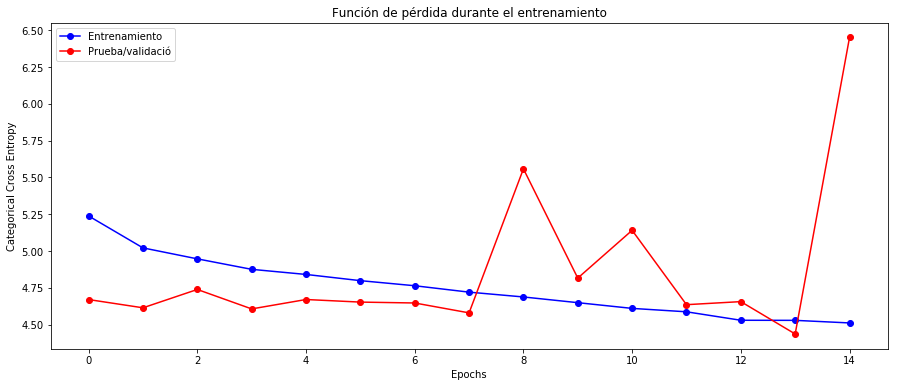

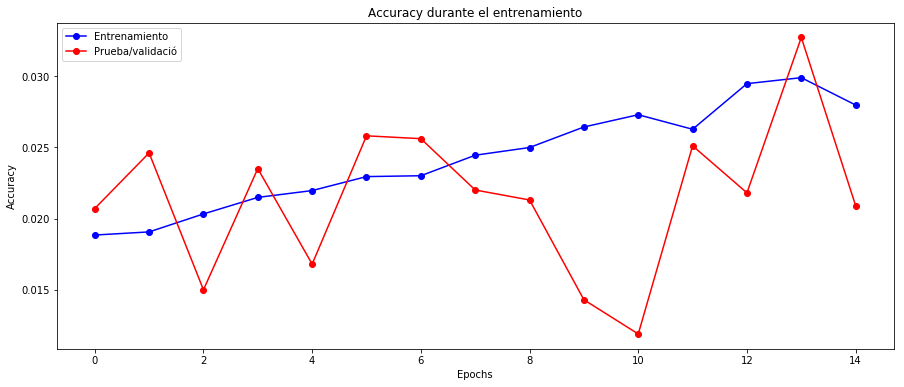

Tiempo de entrenamiento:  11260.525805234909 [s]
Accuracy sobre el conjunto de prueba [6.450414347839356, 0.0209]


In [127]:
epochs_ = 15
results(hist_m5, epochs_, time_m5, acc_test_m5)

Simplemente mirando los gráficos obtenidos y recordando todo lo ya analizado, se puede saber de inmedianto que este modelo es uno de los peores, dado que el rango en que va el accuracy es demasiado bajo, no pudiendo superar ni media centésima. E incluso, viendo el accuracy sobre el conjunto de prueba se logra un pobre 0.0209. Además en el conjunto de prueba se ve el comportamiento irregular a través de los epochs, sin  poder alcanzar una estabilida, aunque en este punto hay que considerar la pequeña cantidad de epochs.

In [151]:
print(tabulate(list(zip(['Red convolucional (a)', 'Red convolucional con autoencoder (c)', 'VGG16 Batch Normalization (f)', 'VGG16 (g)'], 
                        [acc_test_m1[1], acc_m2[1], acc_test_m4[1], acc_test_m5[1]], [time_m1, time_compare2[-1], time_m4, time_m5])),
               ['Modelo', 'Accuracy', 'Tiempo [s]'], tablefmt = "fancy_grid"))

╒═══════════════════════════════════════╤════════════╤══════════════╕
│ Modelo                                │   Accuracy │   Tiempo [s] │
╞═══════════════════════════════════════╪════════════╪══════════════╡
│ Red convolucional (a)                 │     0.4034 │     5613.03  │
├───────────────────────────────────────┼────────────┼──────────────┤
│ Red convolucional con autoencoder (c) │     0.3853 │     6544.28  │
├───────────────────────────────────────┼────────────┼──────────────┤
│ VGG16 Batch Normalization (f)         │     0.3855 │      190.424 │
├───────────────────────────────────────┼────────────┼──────────────┤
│ VGG16 (g)                             │     0.0209 │    11260.5   │
╘═══════════════════════════════════════╧════════════╧══════════════╛


Finalmente comparando todos los modelos entrenado en la actividad, se ve que claramente el último modelo entrenado no es competitivo, pues es considerablemente deficiente en comparación al resto. Luego, comparando las otras tres redes, se ve un accuracy bastante parecido, variando como máximo en 0.018. Por esto, es que se toma en consideración el tiempo empleado para entrenar cada red. Con esto, se ve la superioridad de utilizar los pesos entrenados por el modelo VGG16 y añadiendo batch normalization en las capas densas. 

De esta forma, para estos experimentos la mejor red encontrada es la entrenada en la letra f.